In [1]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
import numpy as np
import torch
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import timm  # pip install timm
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\main\miniconda3\envs\PoseDetect-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 4. Dataset 클래스 정의 (예시)
class PostureDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row["filename"])
        image = Image.open(image_path).convert("RGB")
        label = row["class_id"]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
class EarlyStopping:
    def __init__(self, patience=30, delta=0.0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"🟡 EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                print("🛑 EarlyStopping triggered! Stopping training.")
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """Validation loss가 개선될 때만 모델 저장"""
        torch.save(model.state_dict(), self.checkpoint_path)
        print(f"✅ Model saved to {self.checkpoint_path}")

In [4]:
# CSV 불러오기
# 1. CSV 파일 불러오기
train_df = pd.read_csv("../dataset-modification/train_pose_parsed.csv")[["filename", "class_id"]]
valid_df = pd.read_csv("../dataset-modification/valid_pose_parsed.csv")[["filename", "class_id"]]

df_train_grouped = train_df.groupby("filename")["class_id"].min().reset_index()
df_valid_grouped = valid_df.groupby("filename")["class_id"].min().reset_index()

train_df = df_train_grouped
valid_df = df_valid_grouped

# 필요한 컬럼만 사용
# df = df[["filename", "class_id"]]

# # train/val 나누기
# train_df, val_df = train_test_split(df, stratify=df["class_id"], test_size=0.2, random_state=42)
# df["class_id"].value_counts()

class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_df["class_id"])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [5]:
# 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 이미지 경로 정의
train_image_dir = "../dataset-modification/train-visualized/images/"
valid_image_dir = "../dataset-modification/valid-visualized/images/"

# Dataset 생성
train_dataset = PostureDataset(train_df, train_image_dir, transform)
val_dataset = PostureDataset(valid_df, valid_image_dir, transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print("Train 클래스 분포:\n", train_df["class_id"].value_counts())
print("Valid 클래스 분포:\n", valid_df["class_id"].value_counts())
print("Class weights:", class_weights_tensor)


Train 클래스 분포:
 0    1586
1     995
Name: class_id, dtype: int64
Valid 클래스 분포:
 0    408
1    292
Name: class_id, dtype: int64
Class weights: tensor([0.8137, 1.2970])


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.95, 1.05)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_dataset = PostureDataset(train_df, train_image_dir, transform=train_transform)
val_dataset = PostureDataset(valid_df, valid_image_dir, transform=val_transform)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.BatchNorm1d(in_features),
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 1)
)
model = model.to(device)

In [8]:
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1].to(device))  # class_weight
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(loader, is_train=True):
    model.train() if is_train else model.eval()
    running_loss = 0.0
    preds, labels = [], []

    for images, targets in loader:
        images = images.to(device)
        targets = targets.float().to(device).unsqueeze(1)

        if is_train:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, targets)

        if is_train:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds_batch = (torch.sigmoid(outputs).detach().cpu().numpy() > 0.5).astype(int)
        targets_batch = targets.detach().cpu().numpy().astype(int)

        preds.extend(preds_batch)
        labels.extend(targets_batch)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)

    return running_loss / len(loader.dataset), acc, f1



In [9]:
from torchvision import models, transforms
import torch.nn as nn
import torch


# EfficientNetB0 백본 불러오기
backbone = models.efficientnet_b0(pretrained=True)
backbone.classifier = nn.Identity()  # 분류기 제거 → feature만 추출
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = PostureDataset(train_df, train_image_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


c:\Users\main\miniconda3\envs\PoseDetect-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\main\miniconda3\envs\PoseDetect-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def get_backbone(name):
    if name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Identity()
    elif name == 'resnet50':
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Identity()
    elif name == 'mobilenet_v3_small':
        model = models.mobilenet_v3_small(pretrained=True)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Identity()
    elif name == 'convnext_tiny':
        model = models.convnext_tiny(pretrained=True)
        in_features = model.classifier[2].in_features
        model.classifier = nn.Identity()
    else:
        raise ValueError(f"Unknown model name: {name}")
    
    return model, in_features


In [11]:
def get_mlp_head(in_features):
    return nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 1)
    )


In [12]:
import torch
from torchvision import models
import torch.nn as nn

model_name = 'convnext_tiny'  # 또는 'efficientnet_b0', 'mobilenet_v3_small', 'convnext_tiny'

backbone, in_features = get_backbone(model_name)
head = get_mlp_head(in_features)

model = nn.Sequential(
    backbone,
    head
)

model.eval()
features = []
labels = []

# with torch.no_grad():
#     for imgs, lbls in train_loader:
#         output = model(imgs).squeeze()
#         features.append(output.cpu())
#         labels.append(lbls.cpu())

with torch.no_grad():
    for imgs, lbls in train_loader:
        feat = backbone(imgs)  # output: (batch_size, feature_dim)
        features.append(feat.cpu())
        labels.append(lbls.cpu())

features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()


c:\Users\main\miniconda3\envs\PoseDetect-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)  # (N, D) → (N, 2)

plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title("Feature Embedding (t-SNE)")
plt.colorbar(label="class_id")
plt.show()


NameError: name 'features' is not defined

c:\Users\main\miniconda3\envs\PoseDetect-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


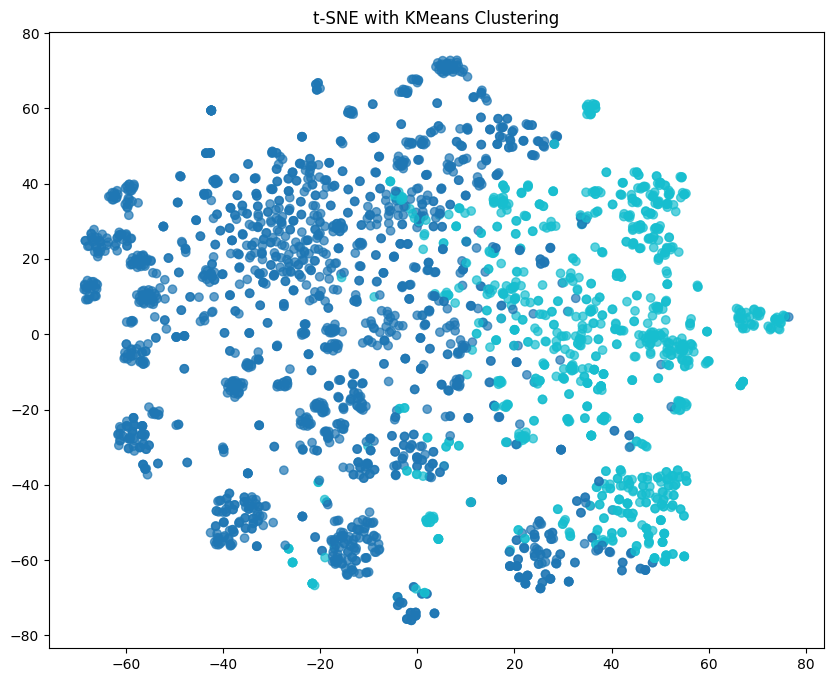

In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# KMeans 클러스터링 (2개 군집 가정)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(features)  # 원본 1280차원 feature

# t-SNE 좌표에 군집 색상 입히기
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("t-SNE with KMeans Clustering")
plt.show()


In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# 실제 라벨 vs KMeans 클러스터 예측
# cluster_labels: KMeans 결과 (0 또는 1)
# labels: 실제 class_id (0 또는 1)

# 경우에 따라 cluster_label의 의미가 반대일 수 있으므로 정확도 양쪽 다 확인
from sklearn.metrics import accuracy_score, confusion_matrix

acc1 = accuracy_score(labels, cluster_labels)
acc2 = accuracy_score(labels, 1 - cluster_labels)  # 반전

print("Matching accuracy:", max(acc1, acc2))
print(confusion_matrix(labels, cluster_labels))
print(confusion_matrix(labels, 1 - cluster_labels))


Matching accuracy: 0.5369288904156647
[[1176  611]
 [ 737  387]]
[[ 611 1176]
 [ 387  737]]


In [44]:
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch

# ✅ 사용자 정의 Dataset
class PostureDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.loc[idx, 'filename'])
        image = Image.open(img_path).convert("RGB")
        label = self.df.loc[idx, 'class_id']
        if self.transform:
            image = self.transform(image)
        return image, label

# ✅ Transform 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ✅ DataFrame 불러오기 (예시)
train_df = pd.read_csv("../dataset-modification/train_pose_parsed.csv")[["filename", "class_id"]]
train_image_dir = "../dataset-modification/train-visualized/images"

# ✅ DataLoader 구성
train_dataset = PostureDataset(train_df, train_image_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


In [45]:
from torchvision import models
import torch.nn.functional as F

# 모델 로드 및 분류기 제거
backbone = models.convnext_tiny(pretrained=True)
backbone.classifier = torch.nn.Identity()  # classifier 제거
backbone.eval()

features = []
labels = []

with torch.no_grad():
    for imgs, lbls in train_loader:
        feat = backbone(imgs)              # shape: (N, C, H, W)
        feat = F.adaptive_avg_pool2d(feat, (1, 1))  # (N, C, 1, 1)
        feat = feat.view(feat.size(0), -1)          # (N, C)
        features.append(feat.cpu())
        labels.append(lbls.cpu())

features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()


In [23]:
def save_epoch_data(epoch, features, labels, setname, backbone, save_dir='embeddings'):
    os.makedirs(f"{save_dir}/{backbone}", exist_ok=True)
    np.save(f"{save_dir}/{backbone}/epoch_{epoch:03d}_{setname}_features.npy", features)
    np.save(f"{save_dir}/{backbone}/epoch_{epoch:03d}_{setname}_labels.npy", labels)


In [ ]:
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch

# ✅ ResNet50 Backbone 준비
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Identity()  # feature만 뽑기
resnet.eval()

# ✅ MLP Head (선택)
mlp_head = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1)
)

model = nn.Sequential(resnet, mlp_head)

# model = nn.Sequential(resnet)

# ✅ Loss & Optimizer 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ TensorBoard
writer = SummaryWriter(log_dir="runs/resnet50_posture_clustering")
log_interval = 1
num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ 학습 루프 + 임베딩 기록
# 학습 루프 내부
for epoch in range(num_epochs):
    model.train()
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device).float()
        output = model(imgs).squeeze()
        loss = criterion(output, lbls)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # ✅ epoch마다 feature 기록 (train + val)
    if epoch % log_interval == 0:
        model.eval()
        def extract_features(dataloader, setname):
            features_list, labels_list = [], []
            with torch.no_grad():
                for imgs, lbls in dataloader:
                    imgs, lbls = imgs.to(device), lbls.to(device)
                    feats = resnet(imgs)
                    features_list.append(feats.cpu())
                    labels_list.append(lbls.cpu())
            all_feats = torch.cat(features_list, dim=0).numpy()
            all_lbls = torch.cat(labels_list, dim=0).numpy()
            save_epoch_data(epoch, all_feats, all_lbls, setname, backbone="resnet50")

        extract_features(train_loader, setname="train")
        extract_features(val_loader, setname="val")
writer.close()


In [17]:
def batch_visualize_tsne(backbone, embedding_dir='embeddings', save_dir='logs'):
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    path = os.path.join(embedding_dir, backbone)
    files = sorted([f for f in os.listdir(path) if f.endswith("_features.npy")])

    for file in files:
        epoch = int(file.split('_')[1])
        features = np.load(os.path.join(path, file))
        labels = np.load(os.path.join(path, file.replace("features.npy", "labels.npy")))

        # 축소 (선택적 PCA → t-SNE)
        reduced = PCA(n_components=50).fit_transform(features)
        embedded = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(reduced)

        # 시각화
        plt.figure(figsize=(8, 8))
        scatter = plt.scatter(embedded[:, 0], embedded[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter)
        plt.title(f"{backbone} - Epoch {epoch:03d}")

        os.makedirs(f"{save_dir}/{backbone}", exist_ok=True)
        plt.savefig(f"{save_dir}/{backbone}/epoch_{epoch:03d}.png")
        plt.close()


In [18]:
batch_visualize_tsne("resnet50")
# make_embedding_gif("resnet50")

In [19]:
def make_embedding_gif(backbone, img_dir="logs", output_dir="outputs"):
    import os
    import glob
    import imageio

    os.makedirs(output_dir, exist_ok=True)
    img_paths = sorted(glob.glob(f"{img_dir}/{backbone}/epoch_*.png"))
    if not img_paths:
        print("⚠️ PNG가 없습니다. 먼저 batch_visualize_tsne 실행하세요.")
        return
    frames = [imageio.imread(p) for p in img_paths]
    imageio.mimsave(f"{output_dir}/{backbone}.gif", frames, duration=0.8)


In [20]:
make_embedding_gif("resnet50")

C:\Users\main\AppData\Local\Temp\ipykernel_2744\389429687.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(p) for p in img_paths]


In [ ]:
def visualize_tsne_train_val(epoch, backbone, embedding_dir='embeddings', save_dir='logs'):
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    def load_and_embed(path_feat, path_label):
        features = np.load(path_feat)
        labels = np.load(path_label)
        reduced = PCA(n_components=50).fit_transform(features)
        embedded = TSNE(n_components=2, random_state=42).fit_transform(reduced)
        return embedded, labels

    # 파일 경로
    base = os.path.join(embedding_dir, backbone)
    feat_train = os.path.join(base, f"epoch_{epoch:03d}_train_features.npy")
    lbls_train = os.path.join(base, f"epoch_{epoch:03d}_train_labels.npy")
    feat_val = os.path.join(base, f"epoch_{epoch:03d}_val_features.npy")
    lbls_val = os.path.join(base, f"epoch_{epoch:03d}_val_labels.npy")

    emb_train, y_train = load_and_embed(feat_train, lbls_train)
    emb_val, y_val = load_and_embed(feat_val, lbls_val)

    # subplot 시각화
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].scatter(emb_train[:, 0], emb_train[:, 1], c=y_train, cmap='tab10', alpha=0.7)
    axs[0].set_title(f"Train - Epoch {epoch:03d}")

    axs[1].scatter(emb_val[:, 0], emb_val[:, 1], c=y_val, cmap='tab10', alpha=0.7)
    axs[1].set_title(f"Validation - Epoch {epoch:03d}")

    os.makedirs(f"{save_dir}/{backbone}", exist_ok=True)
    plt.savefig(f"{save_dir}/{backbone}/epoch_{epoch:03d}_trainval.png")
    plt.close()


In [ ]:
def batch_visualize_tsne_trainval(backbone, embedding_dir='embeddings', save_dir='logs'):
    import os
    path = os.path.join(embedding_dir, backbone)
    files = sorted([f for f in os.listdir(path) if f.endswith("_train_features.npy")])
    epochs = [int(f.split('_')[1]) for f in files]

    for epoch in epochs:
        visualize_tsne_train_val(epoch, backbone, embedding_dir, save_dir)
